In [24]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [25]:
def fetch_stock_data(ticker, start="2020-01-01", end="2024-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data  # full DataFrame for more insights

ticker = "AAPL"  # Apple stock
data = fetch_stock_data(ticker)
prices = data["Close"].values  # Closing prices zt end of day

[*********************100%***********************]  1 of 1 completed


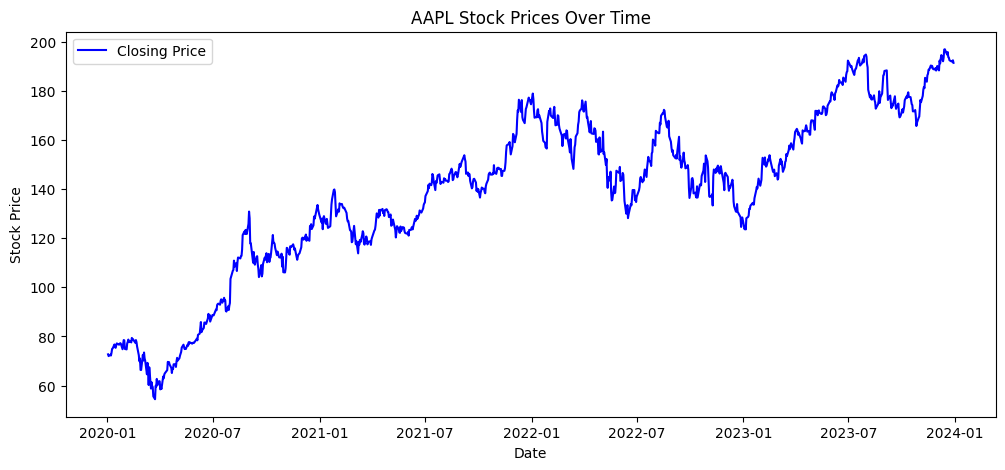

In [26]:
# stock price vs date
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Stock Prices Over Time")
plt.legend()
plt.show()

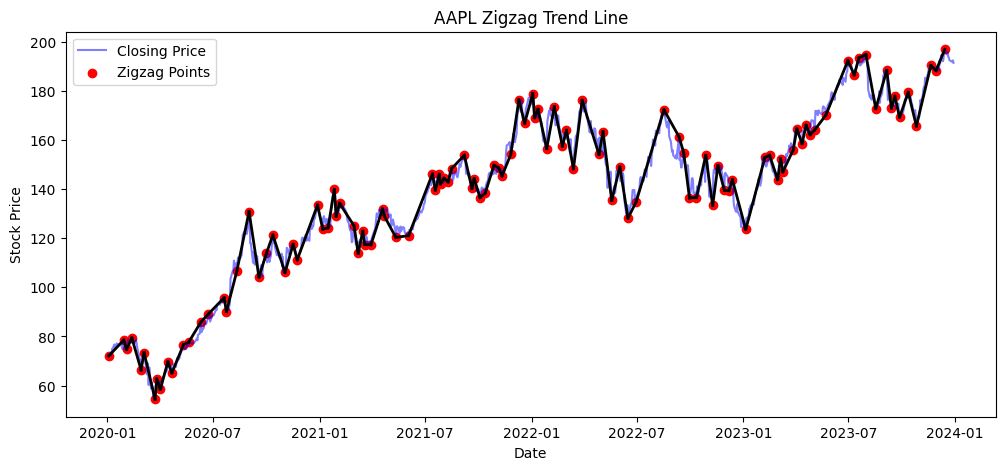

In [27]:
# Zigzag Indicator: Finds peaks & valleys
def zigzag_indicator(prices, order=5):
    peaks = argrelextrema(prices, np.greater, order=order)[0]
    valleys = argrelextrema(prices, np.less, order=order)[0]

    # Combine & sort peaks and valleys chronologically
    zigzag_points = np.sort(np.concatenate((peaks, valleys)))
    return zigzag_points

zigzag_points = zigzag_indicator(prices)

# Plot Zigzag Indicator
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue", alpha=0.5)
plt.scatter(data.index[zigzag_points], prices[zigzag_points], color="red", label="Zigzag Points", marker="o")

# **NEW: Draw proper straight-line Zigzag Trend**
for i in range(len(zigzag_points) - 1):
    x1, x2 = data.index[zigzag_points[i]], data.index[zigzag_points[i + 1]]
    y1, y2 = prices[zigzag_points[i]], prices[zigzag_points[i + 1]]
    plt.plot([x1, x2], [y1, y2], color="black", linewidth=2)  # Straight-line connection

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Zigzag Trend Line")
plt.legend()
plt.show()


In [28]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val), min_val, max_val

scaled_prices, min_price, max_price = min_max_scaling(prices)

In [29]:
split_ratio = 0.8
split_index = int(len(scaled_prices) * split_ratio)
train_data, test_data = scaled_prices[:split_index], scaled_prices[split_index:]

In [30]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Use past 10 days to predict next
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input (batch, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import numpy as np

class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = learning_rate

        # Weights for forget gate
        self.Wf = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bf = np.zeros((hidden_dim, 1))
        
        # Weights for input gate
        self.Wi = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bi = np.zeros((hidden_dim, 1))

        # Weights for candidate memory cell
        self.Wc = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bc = np.zeros((hidden_dim, 1))

        # Weights for output gate
        self.Wo = np.random.randn(hidden_dim, hidden_dim + input_dim) * 0.01
        self.bo = np.zeros((hidden_dim, 1))

        # Output layer
        self.Wy = np.random.randn(output_dim, hidden_dim) * 0.01
        self.by = np.zeros((output_dim, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, x):
        return 1 - x ** 2

    def forward(self, x_seq, h=None, c=None):
        if h is None:
            h = np.zeros((self.hidden_dim, 1))
        if c is None:
            c = np.zeros((self.hidden_dim, 1))

        self.caches = []

        for x in x_seq:
            x = x.reshape(self.input_dim, 1)
            concat = np.vstack((h, x))

            ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
            it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
            c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
            c = ft * c + it * c_tilde
            ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
            h = ot * self.tanh(c)

            self.caches.append((h, c, ft, it, c_tilde, ot, concat))

        y_hat = np.dot(self.Wy, h) + self.by
        
        return y_hat, h, c  


    def backward(self, x_seq, y_hat, y_true):
        dh_next = np.zeros((self.hidden_dim, 1))
        dc_next = np.zeros((self.hidden_dim, 1))

        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWc = np.zeros_like(self.Wc)
        dWo = np.zeros_like(self.Wo)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbc = np.zeros_like(self.bc)
        dbo = np.zeros_like(self.bo)

        dy = y_hat - y_true  # MSE derivative
        dWy = np.dot(dy, self.caches[-1][0].T)
        dby = dy

        dh = np.dot(self.Wy.T, dy) + dh_next
        for t in reversed(range(len(x_seq))):
            h, c, ft, it, c_tilde, ot, concat = self.caches[t]
            c_prev = self.caches[t - 1][1] if t > 0 else np.zeros_like(c)

            do = dh * self.tanh(c)
            do_raw = do * self.dsigmoid(ot)

            dc = dh * ot * self.dtanh(self.tanh(c)) + dc_next
            dc_tilde = dc * it
            dc_tilde_raw = dc_tilde * self.dtanh(c_tilde)

            di = dc * c_tilde
            di_raw = di * self.dsigmoid(it)

            df = dc * c_prev
            df_raw = df * self.dsigmoid(ft)

            dWf += np.dot(df_raw, concat.T)
            dWi += np.dot(di_raw, concat.T)
            dWc += np.dot(dc_tilde_raw, concat.T)
            dWo += np.dot(do_raw, concat.T)

            dbf += df_raw
            dbi += di_raw
            dbc += dc_tilde_raw
            dbo += do_raw

            dconcat = (np.dot(self.Wf.T, df_raw)
                       + np.dot(self.Wi.T, di_raw)
                       + np.dot(self.Wc.T, dc_tilde_raw)
                       + np.dot(self.Wo.T, do_raw))

            dh = dconcat[:self.hidden_dim, :]
            dc_next = dc * ft

        # Update all weights and biases
        self.Wf -= self.lr * dWf
        self.Wi -= self.lr * dWi
        self.Wc -= self.lr * dWc
        self.Wo -= self.lr * dWo
        self.bf -= self.lr * dbf
        self.bi -= self.lr * dbi
        self.bc -= self.lr * dbc
        self.bo -= self.lr * dbo
        self.Wy -= self.lr * dWy
        self.by -= self.lr * dby

    def train(self, X_train, y_train, epochs=10):
        for epoch in range(epochs):
            total_loss = 0
            for i in range(len(X_train)):
                x_seq = X_train[i]
                y_true = y_train[i].reshape(self.output_dim, 1)

                y_hat, _, _ = self.forward(x_seq)
                loss = np.mean((y_hat - y_true) ** 2)
                total_loss += loss

                self.backward(x_seq, y_hat, y_true)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.6f}")


In [49]:
lstm = LSTM(input_dim=1, hidden_dim=128, output_dim=1, learning_rate=0.01)
lstm.train(X_train, y_train, epochs=50)

Epoch 1/50, Loss: 12.759967
Epoch 2/50, Loss: 16.448642
Epoch 3/50, Loss: 16.423906
Epoch 4/50, Loss: 16.383519
Epoch 5/50, Loss: 16.338402
Epoch 6/50, Loss: 16.287463
Epoch 7/50, Loss: 16.229485
Epoch 8/50, Loss: 16.163105
Epoch 9/50, Loss: 16.086797
Epoch 10/50, Loss: 15.998848
Epoch 11/50, Loss: 15.897342
Epoch 12/50, Loss: 15.780140
Epoch 13/50, Loss: 15.644875
Epoch 14/50, Loss: 15.488943
Epoch 15/50, Loss: 15.309513
Epoch 16/50, Loss: 15.103555
Epoch 17/50, Loss: 14.867877
Epoch 18/50, Loss: 14.599200
Epoch 19/50, Loss: 14.294257
Epoch 20/50, Loss: 13.949927
Epoch 21/50, Loss: 13.563414
Epoch 22/50, Loss: 13.132452
Epoch 23/50, Loss: 12.655556
Epoch 24/50, Loss: 12.132277
Epoch 25/50, Loss: 11.563470
Epoch 26/50, Loss: 10.951526
Epoch 27/50, Loss: 10.300551
Epoch 28/50, Loss: 9.616438
Epoch 29/50, Loss: 8.906823
Epoch 30/50, Loss: 8.180886
Epoch 31/50, Loss: 7.449002
Epoch 32/50, Loss: 6.722249
Epoch 33/50, Loss: 6.011831
Epoch 34/50, Loss: 5.328454
Epoch 35/50, Loss: 4.681722
Ep

In [50]:
def predict(lstm, X_test):
    h_prev = np.zeros((lstm.hidden_dim, 1))
    c_prev = np.zeros((lstm.hidden_dim, 1))
    predictions = []

    for i in range(len(X_test)):
        x_seq = X_test[i].reshape(-1, 1)
        x_last = x_seq[-1].reshape(1, 1)
        
        y_pred, h_prev, c_prev = lstm.forward(x_last, h_prev, c_prev)
        predictions.append(y_pred.flatten()[0])

    return np.array(predictions)

# Predict on test set
y_pred_scaled = predict(lstm, X_test)

# Convert back to original scale
y_pred = y_pred_scaled * (max_price - min_price) + min_price
y_test_actual = y_test * (max_price - min_price) + min_price


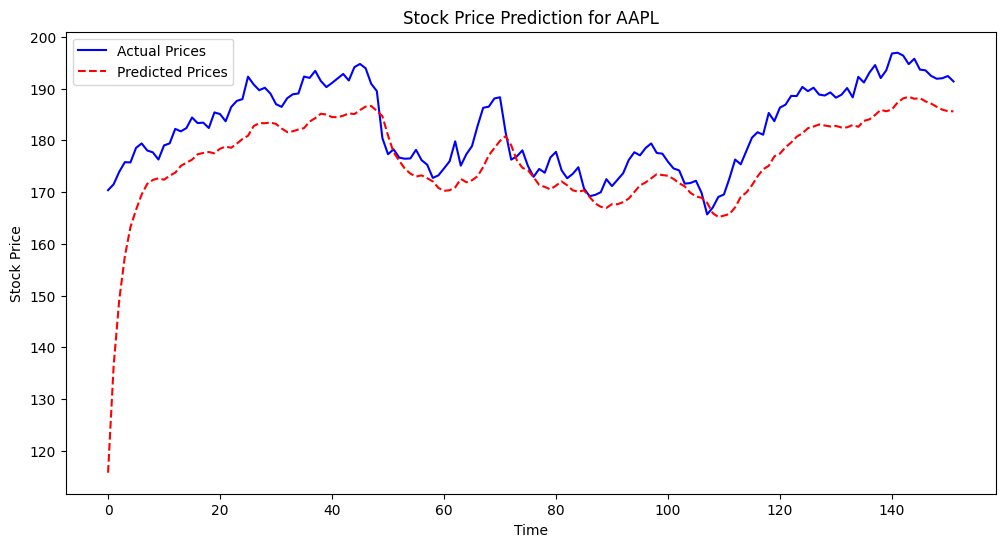

In [51]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"Stock Price Prediction for {ticker}")
plt.legend()
plt.show()

In [52]:
import pandas as pd

# Extract corresponding dates for test set
test_dates = data.index[split_index + seq_length:]  # Align with `y_test`

# Flatten the arrays to 1D
y_test_actual_flat = y_test_actual.flatten()
y_pred_flat = y_pred.flatten()

# Create DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual_flat,
    'Predicted Price': y_pred_flat
})

# Display the table
print(results_df)


          Date  Actual Price  Predicted Price
0   2023-05-24    170.359634       115.746935
1   2023-05-25    171.499756       136.450576
2   2023-05-26    173.918716       149.167734
3   2023-05-30    175.772614       157.574898
4   2023-05-31    175.723053       163.219002
..         ...           ...              ...
147 2023-12-22    192.444595       187.095197
148 2023-12-26    191.897888       186.478533
149 2023-12-27    191.997253       185.927469
150 2023-12-28    192.424713       185.633695
151 2023-12-29    191.380966       185.603499

[152 rows x 3 columns]
